# Test loading functions

### test loading the sepearet forms and see the difference with bk_eq

In [3]:
import numpy as np
import torch
from sep_bk_nn import SepBKNN
from bk_functions import create_bk_dataset
from bk_functions import bk_function_equilateral, bk_function_slow_collider_minus_eq
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt

In [4]:
loaded_model = SepBKNN.load_model('models/sep_bk_nn_test_11.pth', device=torch.device('cuda'))

/global/cfs/cdirs/des/kunhaoz/projects/seperate_bk/sep_bk_nn/sep_bk_nn.py:191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=d

Model loaded from models/sep_bk_nn_test_11.pth


In [5]:
# BK_FUNC = 'bk_eq'
# FUN_ARG = None
# bk_function = bk_function_equilateral

BK_FUNC = 'bk_sl_collider'
FUN_ARG = {'alpha': 0.1}
bk_function = bk_function_slow_collider_minus_eq
    
NUM_TERMS = 2
SYMM_KIND = 2
KMIN = 0.01

batch_size = 512

X_test, y_test = create_bk_dataset(grid_points=1000, func_name=BK_FUNC, func_arg=FUN_ARG, scale_invariant=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [6]:
loaded_model.evaluate((test_loader))

3.20006254116935e-06

In [7]:
loaded_model.test_mse((test_loader))

Test Mean Squared Error: 0.000003


3.20006254116935e-06

In [8]:
alpha = loaded_model.model.alpha
beta = loaded_model.model.beta


In [9]:
### if you want to see some weights

# for name, param in alpha[1].named_parameters():
#     if param.requires_grad:  # Only print parameters that are trainable
#         print(f"Layer: {name}, Weights: {param.data}")

In [10]:
weights_list = loaded_model.model.weights
print(weights_list[0], weights_list[1])

tensor(0.4555, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4245, device='cuda:0', grad_fn=<SelectBackward0>)


In [11]:
print('========== alpha summary ========')
summary(alpha[0], [[1,1,1]])

print('========== beta summary ========')
summary(beta[0], [[1,1,1]])

========== alpha summary ========
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1, 1, 128]             256
              ReLU-2            [-1, 1, 1, 128]               0
            Linear-3             [-1, 1, 1, 64]           8,256
              ReLU-4             [-1, 1, 1, 64]               0
            Linear-5              [-1, 1, 1, 1]              65
Total params: 8,577
Trainable params: 8,577
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
========== beta summary ========
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1, 1,

In [12]:
# alpha[0].to('cpu')
# beta[0].to('cpu')
# weights_list[0].to('cpu')

In [13]:
test_k_val = [0.8018, 0.9012, 1.0000]
test_k1 = test_k_val[0]
test_k2 = test_k_val[1]
test_k3 = test_k_val[2]

test_k_val = torch.as_tensor(test_k_val).to('cuda')
test_k1 = torch.as_tensor(test_k1).view(1).to('cuda')
test_k2 = torch.as_tensor(test_k2).view(1).to('cuda')
test_k3 = torch.as_tensor(test_k3).view(1).to('cuda')


In [14]:
test_result = 0.

for i in range(2):

    alpha_k1 = alpha[i](test_k1)
    beta_k2  = beta[i](test_k2)
    beta_k3  = beta[i](test_k3)

    alpha_k2 = alpha[i](test_k2)
    beta_k1  = beta[i](test_k1)
    beta_k2  = beta[i](test_k2)

    alpha_k3 = alpha[i](test_k3)
    beta_k1  = beta[i](test_k1)
    beta_k2  = beta[i](test_k2)

    test_result += weights_list[i]*(alpha_k1*beta_k2*beta_k3 + alpha_k3*beta_k1*beta_k2 + alpha_k3*beta_k1*beta_k2)

print(test_result)

tensor([1.0435], device='cuda:0', grad_fn=<AddBackward0>)


In [15]:
bk_function(test_k_val[0],test_k_val[1],test_k_val[2])

tensor(1.0234, device='cuda:0')

# plot differences along k1=k2

In [16]:
def get_bk_k1_k2(k1k2=0.1):
    # get the bk from the NN with k1=k2
    result = 0.
    for i in range(2):
        tmp1 = alpha[i](k1k2)
        tmp2  = beta[i](k1k2)
        tmp3  = beta[i](test_k3)

        tmp4 = alpha[i](k1k2)
        tmp5  = beta[i](k1k2)
        tmp6  = beta[i](test_k2)

        tmp7 = alpha[i](test_k3)
        tmp8  = beta[i](k1k2)
        tmp9  = beta[i](k1k2)
        result += weights_list[i]*(tmp1*tmp2*tmp3 + tmp4*tmp5*tmp6 + tmp7*tmp8*tmp9)
    return result

In [17]:
test_k1k2 = np.linspace(0.51, 1., 100).astype(float)
test_result_k1k2 = []
for k1k2 in test_k1k2:
    k1k2 = torch.as_tensor(k1k2).view(1).to('cuda').float()
    test_result_k1k2.append(get_bk_k1_k2(k1k2).detach().cpu().numpy()[0])
test_result_k1k2 = np.array(test_result_k1k2)


true_result_k1k2 = []
for k1k2 in test_k1k2:
    true_result_k1k2.append(bk_function(k1k2, k1k2, 1.0))
    
true_result_k1k2 = np.array(true_result_k1k2)

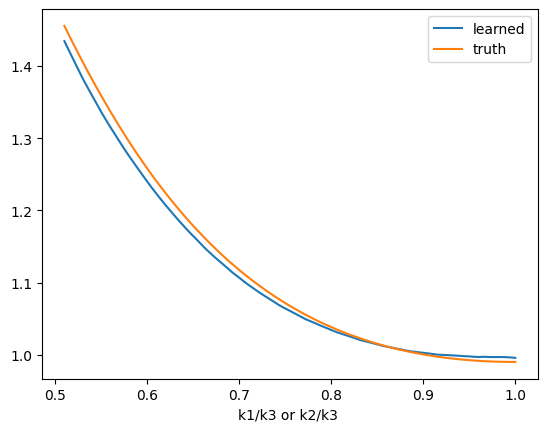

mean of abs residual 0.00808251044167293


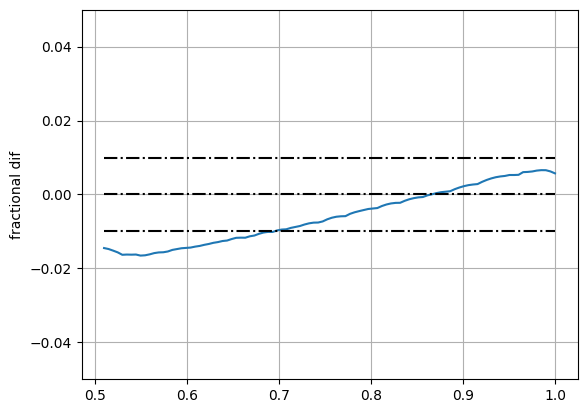

In [18]:
plt.plot(test_k1k2, test_result_k1k2, label='learned')
plt.plot(test_k1k2, true_result_k1k2, label='truth')

plt.xlabel('k1/k3 or k2/k3 ')
plt.legend()
plt.show()

plt.plot(test_k1k2, test_result_k1k2/true_result_k1k2-1)
plt.ylabel('fractional dif')
plt.ylim(-0.05, 0.05)

plt.plot(test_k1k2, 0.01*np.ones(test_k1k2.shape[0]), ls='-.', c='black')
plt.plot(test_k1k2, -0.01*np.ones(test_k1k2.shape[0]), ls='-.', c='black')
plt.plot(test_k1k2, 0.*np.ones(test_k1k2.shape[0]), ls='-.', c='black')

plt.grid()

print('mean of abs residual', np.mean(np.abs(test_result_k1k2/true_result_k1k2-1)))

# plot differences along k1, fixe k2=k3=1.

In [19]:
def get_bk_squeezed(k1k2=0.1):
    # get the bk from the NN with k1=k2
    result = 0.
    for i in range(2):
        tmp1 = alpha[i](k1k2)
        tmp2  = beta[i](test_k3)
        tmp3  = beta[i](test_k3)

        tmp4 = alpha[i](test_k3)
        tmp5  = beta[i](k1k2)
        tmp6  = beta[i](test_k2)

        tmp7 = alpha[i](test_k3)
        tmp8  = beta[i](test_k3)
        tmp9  = beta[i](k1k2)
        result += weights_list[i]*(tmp1*tmp2*tmp3 + tmp4*tmp5*tmp6 + tmp7*tmp8*tmp9)
    return result

In [29]:
test_k1k2 = np.linspace(0.01, 1., 100).astype(float)
test_result_k1k2 = []
for k1k2 in test_k1k2:
    k1k2 = torch.as_tensor(k1k2).view(1).to('cuda').float()
    test_result_k1k2.append(get_bk_squeezed(k1k2).detach().cpu().numpy()[0])
test_result_k1k2 = np.array(test_result_k1k2)


true_result_k1k2 = []
for k1k2 in test_k1k2:
    true_result_k1k2.append(bk_function(k1k2, 1.0, 1.0))
    
true_result_k1k2 = np.array(true_result_k1k2)

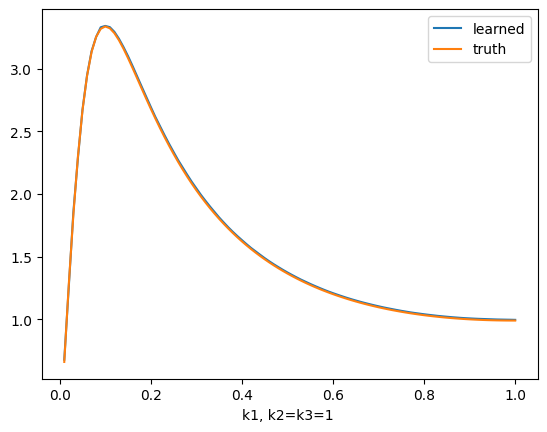

mean of abs residual 0.006470606726452379


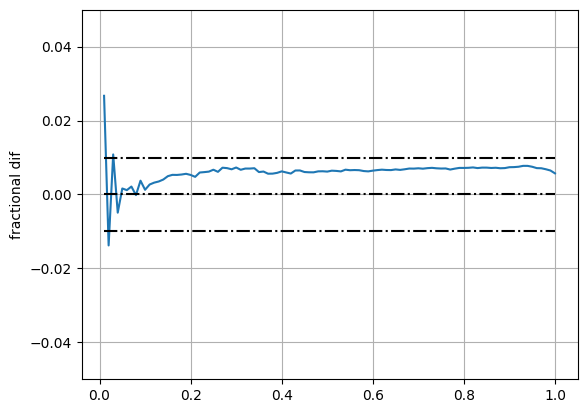

In [32]:
plt.plot(test_k1k2, test_result_k1k2, label='learned')
plt.plot(test_k1k2, true_result_k1k2, label='truth')

plt.xlabel('k1, k2=k3=1 ')
plt.legend()
plt.show()

plt.plot(test_k1k2, test_result_k1k2/true_result_k1k2-1)
plt.ylabel('fractional dif')
plt.ylim(-0.05, 0.05)

plt.plot(test_k1k2, 0.01*np.ones(test_k1k2.shape[0]), ls='-.', c='black')
plt.plot(test_k1k2, -0.01*np.ones(test_k1k2.shape[0]), ls='-.', c='black')
plt.plot(test_k1k2, 0.*np.ones(test_k1k2.shape[0]), ls='-.', c='black')

plt.grid()

print('mean of abs residual', np.mean(np.abs(test_result_k1k2/true_result_k1k2-1)))

In [31]:
weights_list

Parameter containing:
tensor([0.4555, 0.4245], device='cuda:0', requires_grad=True)